##### References
- **[Calculate indicators](#Calculate-indicators)**
    - [Return](#Return)
    - [RSI](#RSI)
    - [Gain/lose](#Gain/lose)
    - [Average gain/loss](#Average-gain/loss)
    - [MA](#MA)
    - [Moving Average Convergence Divergence (MACD)](#Moving-Average-Convergence-Divergence-(MACD))
    - [Stochastic Oscillator](#Stochastic-Oscillator)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
    - [Bollinger Bands](#Bollinger-Bands)

<br>
    
- **[Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)**

    - [RSI](#RSI-decision)
        - [RSI backtesting](#RSI-backtesting)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
        - [Williams backtesting](#Williams-backtesting)
     - [MA](#MA-decision)
        - [MA backtesting](#MA-backtesting)
    - [MACD](#MACD-decision)
        - [MACD backtesting](#MACD-backtesting)
    - [Bollinger Bands](#Bollinger-Bands-decision)
        - [Bollinger Bands](#Bollinger-Bands-backtesting)

    
   


***

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import backtesting
# from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *
import random

import warnings
warnings.filterwarnings("ignore")

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "MAGISTERKA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=400):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data download

In [4]:
# stocks = ['EURUSD=X', '^GSPC']

# start_data = '2019-04-04'  # (RRR-MM-DD)
# end_data = '2024-04-04'  # (RRR-MM-DD)

# for stock in stocks:
#     data = yf.download(stock, start_data, end_data)
#     df = pd.DataFrame(data)
#     df['Name'] = stock  # add column with symbol
#     df.to_csv(stock + '.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Load data

In [10]:
data = pd.read_csv('C:/Users/Karolina/Desktop/MAGISTERKA/dane/EURUSD/eurusd_1h.csv')

In [11]:
data.describe().round(2)

id  data_open  data_close  data_high  data_low  data_volume
count   5318.00    5318.00     5318.00    5318.00   5318.00       5318.0
mean   46857.60       1.08        1.08       1.08      1.08          0.0
std     8615.28       0.02        0.02       0.02      0.02          0.0
min    28851.00       1.05        1.05       1.05      1.04          0.0
25%    41769.25       1.07        1.07       1.07      1.07          0.0
50%    43098.50       1.08        1.08       1.08      1.08          0.0
75%    44427.75       1.09        1.09       1.09      1.09          0.0
max    68836.00       1.13        1.13       1.13      1.13          0.0

In [12]:
data['Name'] = 'EURUSD'

In [13]:
data = data.rename(columns={"data_open": "Open", "data_close": "Close", 'data_high': 'High', 'data_low': 'Low'})

In [27]:
# Convert 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
start, end = '2019-04', '2024-04'
pd.set_option('display.max_columns', None)

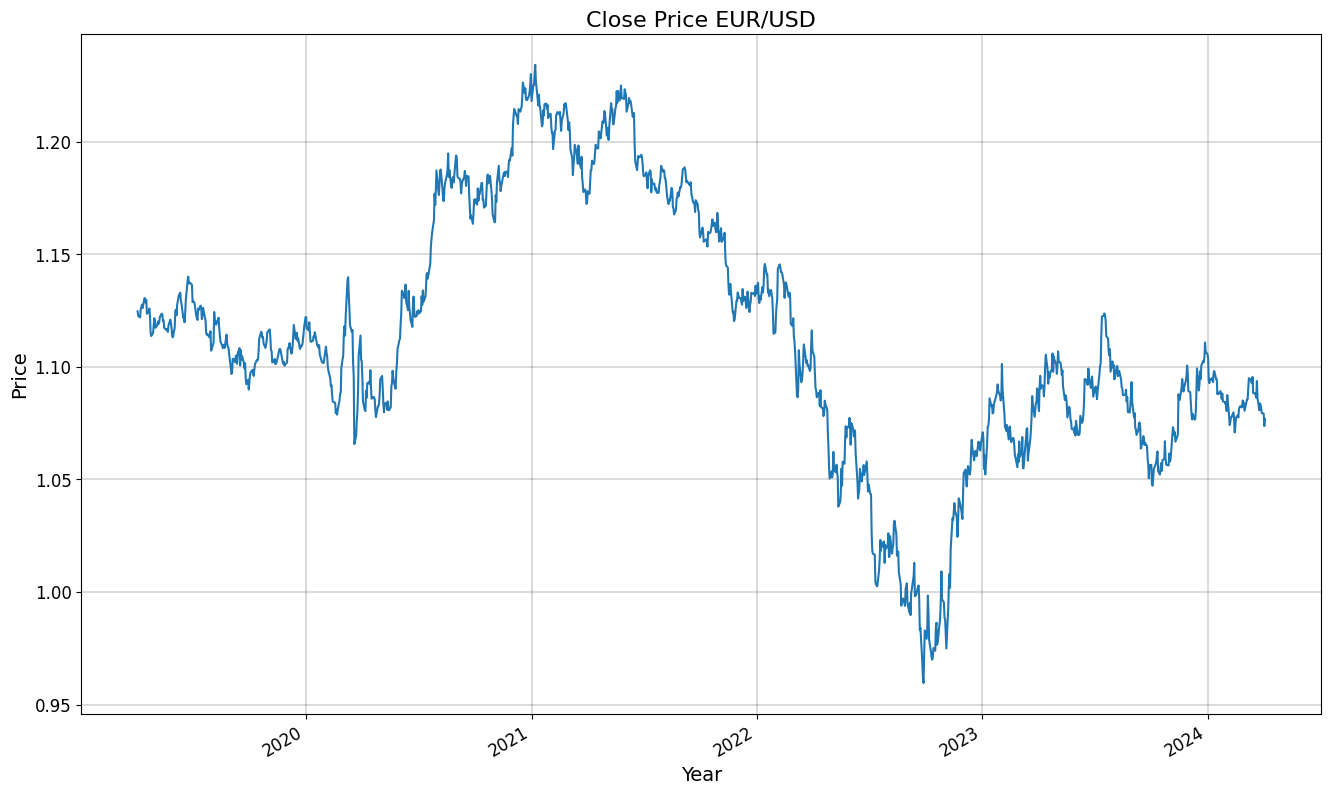

In [28]:
data.groupby('Name')['Close'].plot(figsize=(16, 10))

# Show the legend
#plt.legend(loc = 'upper left')

# Define the label for the title of the figure
plt.title("Close Price EUR/USD", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-', linewidth=0.2)

plt.show()

In [8]:
data.describe()

id         Open        Close         High          Low   
count   7663.000000  7663.000000  7663.000000  7663.000000  7663.000000  \
mean   15216.389795  4136.201152  4136.240010  4141.607138  4130.528083   
std    20813.234137   245.338182   245.381064   243.929626   246.760889   
min     1289.000000  3508.000000  3508.200000  3533.600000  3490.100000   
25%     3275.500000  3960.850000  3960.900000  3966.700000  3954.400000   
50%     5191.000000  4127.600000  4127.700000  4132.200000  4122.200000   
75%     8983.500000  4357.550000  4357.800000  4361.150000  4352.800000   
max    68834.000000  4602.500000  4602.100000  4606.900000  4598.300000   

       data_volume  
count       7663.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0

# Calculate indicators

In [14]:
price_data = data.copy()
price_data.head()

id    name     Open    Close     High      Low  data_volume   
0  40978  EURUSD  1.07075  1.07081  1.07187  1.06999          0.0  \
1  41003  EURUSD  1.07089  1.07070  1.07226  1.07008          0.0   
2  41032  EURUSD  1.06206  1.06412  1.06440  1.06204          0.0   
3  41057  EURUSD  1.06804  1.06888  1.06914  1.06784          0.0   
4  41082  EURUSD  1.06487  1.06854  1.06983  1.06458          0.0   

             data_datetime timeframe    Name  
0  2023-02-15 07:00:00.000        1h  EURUSD  
1  2023-02-16 08:00:00.000        1h  EURUSD  
2  2023-02-17 13:00:00.000        1h  EURUSD  
3  2023-02-20 14:00:00.000        1h  EURUSD  
4  2023-02-21 15:00:00.000        1h  EURUSD

## Return

In [15]:
# Identify rows where the symbol changes
mask = price_data['Name'] != price_data['Name'].shift(1)

# Calculate log return
price_data['Return'] = np.log(price_data['Close']) -  np.log(price_data['Close'].shift(1))

# For rows where symbol changes set null
price_data['Return'] = np.where(mask == True, np.nan, price_data['Return'])


## Gain/lose


In [16]:
# Set '0' if 'Up' is below 0
price_data['Up'] = price_data['Return']
price_data.loc[(price_data['Up']<0), 'Up'] = 0
 
# Set '0' if 'Down' above 0
price_data['Down'] = price_data['Return']
price_data.loc[(price_data['Down']>0), 'Down'] = 0 
 
# Set the absolute value for negative values
price_data['Down'] = abs(price_data['Down'])

## Average gain/loss

In [17]:
# 14-days averages
price_data['avg_14up'] = price_data.groupby('Name')['Up'].transform(lambda x: x.rolling(window=14).mean())
price_data['avg_14down'] = price_data.groupby('Name')['Down'].transform(lambda x: x.rolling(window=14).mean())


## RSI

In [18]:
# Calculate RS

price_data['RS_14'] = price_data['avg_14up'] / price_data['avg_14down']

# Calculate RSI

price_data['RSI'] = 100 - (100/(1 + price_data['RS_14']))

## RSI na cenach
****

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWF6andoNjg5bXowZ3pyNGwyMGV6aGh1ZDhkbTl1bGhpd2Jjd2dkMiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/Nw8z2olm0nGHC/giphy.gif" width="450" align="center">


# [Wzory](https://www.macroption.com/rsi-calculation/)

In [43]:
# Calculate bar-to-bar changes
price_data['chng'] = price_data['Close'].diff()

# Calculate Up moves (U) and Down moves (D)
price_data['Up_c'] = price_data['chng'].copy()
price_data['Down_c'] = price_data['chng'].copy()

# Set 'Up' to 0 if 'chng' is negative or zero
price_data.loc[price_data['chng'] <= 0, 'Up_c'] = 0

# Set 'Down' to 0 if 'chng' is positive or zero
price_data.loc[price_data['chng'] >= 0, 'Down_c'] = 0

price_data['Down_c'] = abs(price_data['Down_c'])


In [77]:
# Calculate simple moving averages for AvgU and AvgD
N = 14  # RSI period

price_data['AvgU_avg'] = price_data['Up_c'].rolling(window=N, min_periods=1).mean()
price_data['AvgD_avg'] = price_data['Down_c'].rolling(window=N, min_periods=1).mean()

price_data['RS_avg'] =price_data['AvgU_avg']/ price_data['AvgD_avg']

In [78]:
price_data['RSI_avg'] = 100 - (100/(1+price_data['RS_avg']))

In [50]:
price_data.tail(15)

Open      High       Low     Close  Adj Close  Volume   
Date                                                                    
2024-03-14  1.095530  1.095470  1.088412  1.095530   1.095530       0  \
2024-03-15  1.088341  1.090156  1.087382  1.088341   1.088341       0   
2024-03-18  1.088258  1.090750  1.088080  1.088258   1.088258       0   
2024-03-19  1.087394  1.087784  1.083506  1.087394   1.087394       0   
2024-03-20  1.086331  1.087429  1.083694  1.086331   1.086331       0   
2024-03-21  1.093721  1.094451  1.085647  1.093721   1.093721       0   
2024-03-22  1.086236  1.086957  1.080906  1.086236   1.086236       0   
2024-03-25  1.080754  1.084363  1.080264  1.080754   1.080754       0   
2024-03-26  1.083823  1.086413  1.082603  1.083823   1.083823       0   
2024-03-27  1.083236  1.083929  1.081175  1.083236   1.083236       0   
2024-03-28  1.081338  1.082837  1.077551  1.081338   1.081338       0   
2024-03-29  1.079447  1.080731  1.076890  1.079447   1.079447       0   
2024-04-01  1.079273  1.080147  1.073157  1.079273   1.079273       0   
2024-04-02  1.073722  1.077877  1.072536  1.073722   1.073722       0   
2024-04-03  1.076855  1.083189  1.076473  1.076855   1.076855       0   

                Name    Return      chng        Up      Down      AvgU   
Date                                                                     
2024-03-14  EURUSD=X  0.002517  0.002753  0.002517  0.000000  0.001454  \
2024-03-15  EURUSD=X -0.006584 -0.007190  0.000000  0.006584  0.001454   
2024-03-18  EURUSD=X -0.000076 -0.000083  0.000000  0.000076  0.001234   
2024-03-19  EURUSD=X -0.000794 -0.000864  0.000000  0.000794  0.001234   
2024-03-20  EURUSD=X -0.000978 -0.001063  0.000000  0.000978  0.001234   
2024-03-21  EURUSD=X  0.006780  0.007390  0.006780  0.000000  0.001762   
2024-03-22  EURUSD=X -0.006867 -0.007485  0.000000  0.006867  0.001492   
2024-03-25  EURUSD=X -0.005060 -0.005482  0.000000  0.005060  0.001403   
2024-03-26  EURUSD=X  0.002836  0.003069  0.002836  0.000000  0.001616   
2024-03-27  EURUSD=X -0.000542 -0.000587  0.000000  0.000542  0.001305   
2024-03-28  EURUSD=X -0.001753 -0.001898  0.000000  0.001753  0.000944   
2024-03-29  EURUSD=X -0.001750 -0.001891  0.000000  0.001750  0.000944   
2024-04-01  EURUSD=X -0.000162 -0.000175  0.000000  0.000162  0.000944   
2024-04-02  EURUSD=X -0.005156 -0.005551  0.000000  0.005156  0.000944   
2024-04-03  EURUSD=X  0.002914  0.003133  0.002914  0.000000  0.000971   

                AvgD        RS        RSI  avg_14up  avg_14down     RS_14   
Date                                                                        
2024-03-14  0.000528  2.752684  73.318689  0.001337    0.000486  2.747942  \
2024-03-15  0.001002  1.451783  59.241470  0.001337    0.000920  1.453474   
2024-03-18  0.001008  1.224343  55.053553  0.001133    0.000925  1.224870   
2024-03-19  0.001026  1.202864  54.617621  0.001133    0.000941  1.203498   
2024-03-20  0.001059  1.165231  53.829375  0.001133    0.000972  1.165879   
2024-03-21  0.000817  2.156218  68.363506  0.001617    0.000748  2.160906   
2024-03-22  0.001352  1.103944  52.482426  0.001368    0.001239  1.104485   
2024-03-25  0.001743  0.804825  44.559249  0.001286    0.001600  0.803727   
2024-03-26  0.001743  0.927198  48.103029  0.001483    0.001600  0.926895   
2024-03-27  0.001785  0.731186  42.215483  0.001197    0.001639  0.730567   
2024-03-28  0.001921  0.491384  32.938791  0.000867    0.001764  0.491175   
2024-03-29  0.002004  0.470859  31.989066  0.000867    0.001842  0.470352   
2024-04-01  0.001934  0.488002  32.765883  0.000867    0.001778  0.487340   
2024-04-02  0.002305  0.409473  28.985920  0.000867    0.002123  0.408171   
2024-04-03  0.002305  0.421247  29.653946  0.000895    0.002123  0.421544   

                Up_c    Down_c      RSI_c  
Date                                       
2024-03-14  0.002753  0.000000  73.352404  
2024-03-15  0.000000  0.007190  59.213364  
2024-03-18  0.000000  0.00008

### Wilder's Smoothing Method

In [72]:

# Calculate bar-to-bar changes
price_data['chng'] = price_data['Close'].diff()

# Calculate Up moves (U) and Down moves (D)
price_data['Up_c'] = price_data['chng'].copy()
price_data['Down_c'] = price_data['chng'].copy()

# Set 'Up' to 0 if 'chng' is negative or zero
price_data.loc[price_data['chng'] <= 0, 'Up_c'] = 0

# Set 'Down' to 0 if 'chng' is positive or zero
price_data.loc[price_data['chng'] >= 0, 'Down_c'] = 0

price_data['Down_c'] = abs(price_data['Down_c'])

# Calculate Wilder's smoothing method for AvgU and AvgD
N = 14  # RSI period

price_data['AvgU'] = 0.0
price_data['AvgD'] = 0.0

# Calculate initial values for AvgU and AvgD
price_data.loc[price_data.index[N-1], 'AvgU'] = price_data['Up_c'].iloc[:N].mean()
price_data.loc[price_data.index[N-1], 'AvgD'] = price_data['Down_c'].iloc[:N].mean()

# Calculate AvgU and AvgD using Wilder's smoothing method
for i in range(N, len(price_data)):
    price_data.loc[price_data.index[i], 'AvgU'] = (1/N) * price_data['Up_c'].iloc[i] + ((N - 1)/N) * price_data['AvgU'].iloc[i-1]
    price_data.loc[price_data.index[i], 'AvgD'] = (1/N) * price_data['Down_c'].iloc[i] + ((N - 1)/N) * price_data['AvgD'].iloc[i-1]

# Calculate RS and RSI using AvgU and AvgD
price_data['RS'] = price_data['AvgU'] / price_data['AvgD']
price_data['RSI_c'] = 100 - (100 / (1 + price_data['RS']))


In [73]:
price_data.dropna()
price_data.iloc[19:50].head(20)

Date      Open      High       Low     Close  Adj Close  Volume   
19  2019-05-01  1.121831  1.124999  1.121441  1.121604   1.121604       0  \
20  2019-05-02  1.120185  1.121818  1.117356  1.120084   1.120084       0   
21  2019-05-03  1.117256  1.120072  1.114132  1.117356   1.117356       0   
22  2019-05-06  1.118706  1.120448  1.117993  1.118581   1.118581       0   
23  2019-05-07  1.120448  1.121957  1.117606  1.120185   1.120185       0   
24  2019-05-08  1.118956  1.121500  1.118956  1.119107   1.119107       0   
25  2019-05-09  1.119746  1.125100  1.117568  1.119833   1.119833       0   
26  2019-05-10  1.121856  1.125239  1.121856  1.122208   1.122208       0   
27  2019-05-13  1.123671  1.126342  1.122410  1.123646   1.123646       0   
28  2019-05-14  1.123242  1.124606  1.120486  1.123255   1.123255       0   
29  2019-05-15  1.120360  1.122272  1.118043  1.120448   1.120448       0   
30  2019-05-16  1.120951  1.122435  1.117431  1.120724   1.120724       0   
31  2019-05-17  1.117481  1.118443  1.115735  1.117356   1.117356       0   
32  2019-05-20  1.116532  1.117701  1.115126  1.116532   1.116532       0   
33  2019-05-21  1.116944  1.118318  1.114243  1.116857   1.116857       0   
34  2019-05-23  1.115511  1.117281  1.110951  1.115548   1.115548       0   
35  2019-05-24  1.118381  1.121202  1.117805  1.118456   1.118456       0   
36  2019-05-27  1.120636  1.121831  1.118806  1.120963   1.120963       0   
37  2019-05-28  1.119357  1.119946  1.117181  1.119382   1.119382       0   
38  2019-05-29  1.117069  1.117568  1.112595  1.117069   1.117069       0   

        Name    Return        Up      Down  avg_14up  avg_14down     RS_14   
19  EURUSD=X  0.002755  0.002755  0.000000  0.001009    0.001393  0.724430  \
20  EURUSD=X -0.001356  0.000000  0.001356  0.001009    0.001390  0.725960   
21  EURUSD=X -0.002439  0.000000  0.002439  0.000729    0.001565  0.465894   
22  EURUSD=X  0.001096  0.001096  0.000000  0.000807    0.001564  0.516176   
23  EURUSD=X  0.001433  0.001433  0.000000  0.000910    0.001438  0.632523   
24  EURUSD=X -0.000963  0.000000  0.000963  0.000833    0.001507  0.552800   
25  EURUSD=X  0.000649  0.000649  0.000000  0.000879    0.001119  0.785891   
26  EURUSD=X  0.002119  0.002119  0.000000  0.000976    0.001119  0.872352   
27  EURUSD=X  0.001280  0.001280  0.000000  0.000976    0.001119  0.872191   
28  EURUSD=X -0.000348  0.000000  0.000348  0.000976    0.000924  1.056439   
29  EURUSD=X -0.002502  0.000000  0.002502  0.000976    0.000650  1.501144   
30  EURUSD=X  0.000246  0.000246  0.000000  0.000993    0.000543  1.828232   
31  EURUSD=X -0.003010  0.000000  0.003010  0.000908    0.000758  1.196581   
32  EURUSD=X -0.000737  0.000000  0.000737  0.000684    0.000811  0.843513   
33  EURUSD=X  0.000290  0.000290  0.000000  0.000508    0.000811  0.626441   
34  EURUSD=X -0.001172  0.000000  0.001172  0.000508    0.000798  0.636773   
35  EURUSD=X  0.002603  0.002603  0.000000  0.000694    0.000624  1.112652   
36  EURUSD=X  0.002239  0.002239  0.000000  0.000776    0.000624  1.243631   
37  EURUSD=X -0.001411  0.000000  0.001411  0.000673    0.000725  0.929348   
38  EURUSD=X -0.002069  0.000000  0.002069  0.000673    0.000804  0.837990   

          RSI      chng      Up_c    Down_c      AvgU      AvgD        RS   
19  42.009839  0.003086  0.003086  0.000000  0.001207  0.001255  0.961562  \
20  42.061230 -0.001520  0.000000  0.001520  0.001121  0.001274  0.879627   
21  31.782222 -0.002728  0.000000  0.002728  0.001041  0.001378  0.755246   
22  34.044584  0.001225  0.001225  0.000000  0.001054  0.001280  0.823614   
23  38.745106  0.001604  0.001604  0.000000  0.001093  0.001188  0.920021   
24  35.600215 -0.001078  0.000000  0.001078  0.001015  0.001180  0.860000   
25  44.005533  0.000727  0.000727  0.000000  0.000995  0.001096  0.907363   
26  46.591245  0.002375  0.002375  0.000000  0.001093  0.001018  1.074045   
27  46.586644  0.001438  0.001438  0.000000  0.001118  0.000

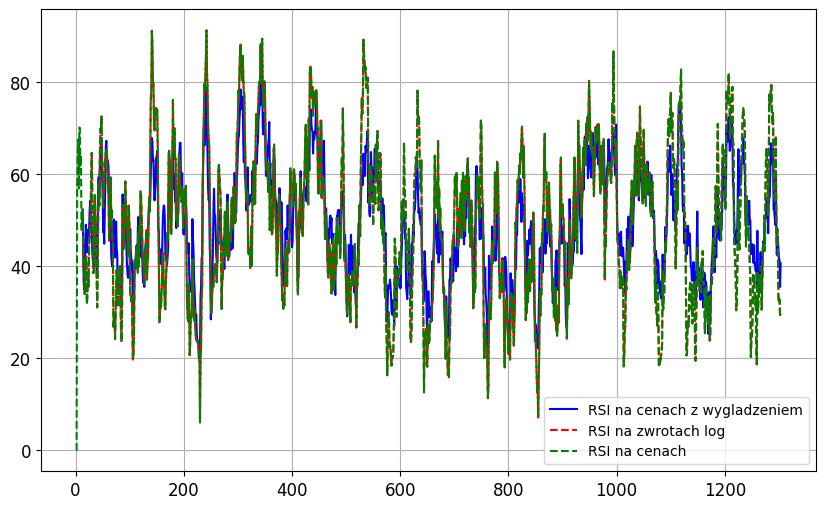

In [81]:
plt.figure(figsize=(10, 6))


plt.plot(price_data.index, price_data['RSI_c'], label='RSI na cenach z wygladzeniem', color='blue')

plt.plot(price_data.index, price_data['RSI'], label='RSI na zwrotach log', color='red', linestyle='dashed')
plt.plot(price_data.index, price_data['RSI_avg'], label='RSI na cenach', color='green', linestyle='dashed')

plt.legend()


plt.grid(True)
plt.show()


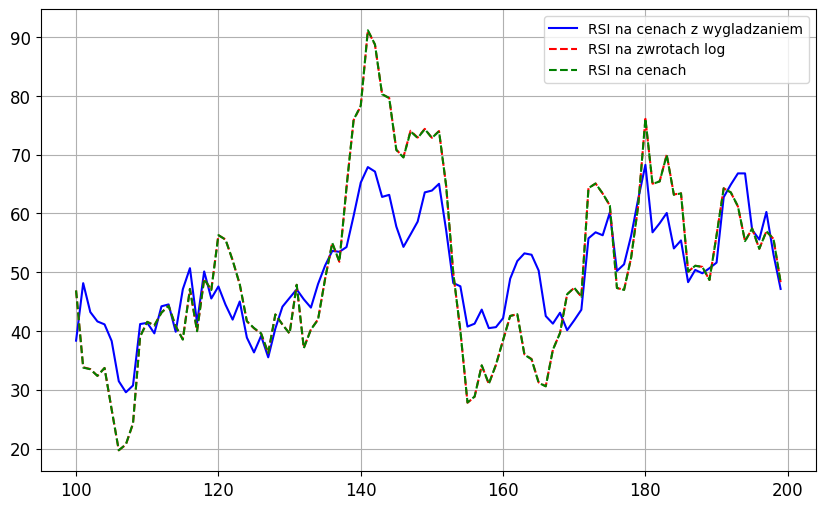

In [83]:
plt.figure(figsize=(10, 6))


plt.plot(price_data.iloc[100:200].index, price_data['RSI_c'].iloc[100:200], label='RSI na cenach z wygladzaniem', color='blue')

plt.plot(price_data.iloc[100:200].index, price_data['RSI'].iloc[100:200], label='RSI na zwrotach log', color='red', linestyle='dashed')
plt.plot(price_data.iloc[100:200].index, price_data['RSI_avg'].iloc[100:200], label='RSI na cenach', color='green', linestyle='dashed')

plt.legend()


plt.grid(True)
plt.show()


****

## Pozostałe wskaźniki:

## MA

In [19]:
price_data["5MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 5).mean())
price_data["15MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 15).mean())

## Moving Average Convergence Divergence (MACD)

In [20]:
# Calculate 12 and 26 EWM
price_data['12Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
price_data['26Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

# Calculate MACD
price_data['MACD'] = price_data['12Ewm'] - price_data['26Ewm']


## Stochastic Oscillator

In [21]:
# Period
n = 14

# Group by the symbol and then take max and min 
price_data['low_14'] = price_data.groupby('Name')['Low'].transform(lambda x: x.rolling(window = n).min())
price_data['high_14'] = price_data.groupby('Name')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the stochastic oscillator
price_data['k_percent']  = 100 * ((price_data['Close'] - price_data['low_14']) / (price_data['high_14'] - price_data['low_14']))

## Williams %R ('r_percent')

In [22]:
# Period
n = 14

# Calculate Williams %R
price_data['r_percent'] = -100 * ((price_data['high_14'] - price_data['Close']) / (price_data['high_14'] - price_data['low_14']))



## Bollinger Bands
[Bollinger Bands](https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/)

In [23]:
def bollinger_bands(df, n, m):
    result = df.copy()  
    
    # Initialize new columns with NaN values
    result['B_MA'] = np.nan
    result['BU'] = np.nan
    result['BL'] = np.nan
    
    grouped = df.groupby('Name')
    
    for name, group in grouped:
        data = group['Close']
        
        B_MA = data.rolling(n, min_periods=n).mean()
        sigma = data.rolling(n, min_periods=n).std()
        
        BU = B_MA + m * sigma
        BL = B_MA - m * sigma
        
        # Assign calculated values to the corresponding rows in the result DataFrame
        result.loc[group.index, 'B_MA'] = B_MA
        result.loc[group.index, 'BU'] = BU
        result.loc[group.index, 'BL'] = BL
    
    return result

In [24]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(price_data, 20, 2)

In [25]:
df.head(20)

id    name     Open    Close     High      Low  data_volume   
0   40978  EURUSD  1.07075  1.07081  1.07187  1.06999          0.0  \
1   41003  EURUSD  1.07089  1.07070  1.07226  1.07008          0.0   
2   41032  EURUSD  1.06206  1.06412  1.06440  1.06204          0.0   
3   41057  EURUSD  1.06804  1.06888  1.06914  1.06784          0.0   
4   41082  EURUSD  1.06487  1.06854  1.06983  1.06458          0.0   
5   41112  EURUSD  1.06026  1.06049  1.06055  1.06013          0.0   
6   41116  EURUSD  1.06117  1.06197  1.06218  1.06110          0.0   
7   41162  EURUSD  1.05464  1.05534  1.05554  1.05456          0.0   
8   41192  EURUSD  1.05902  1.05846  1.05907  1.05820          0.0   
9   41217  EURUSD  1.05909  1.06072  1.06148  1.05893          0.0   
10  41232  EURUSD  1.06648  1.06690  1.06712  1.06646          0.0   
11  41272  EURUSD  1.06128  1.06224  1.06296  1.06106          0.0   
12  41297  EURUSD  1.06541  1.06689  1.06736  1.06503          0.0   
13  41322  EURUSD  1.06480  1.05856  1.06480  1.05740          0.0   
14  41352  EURUSD  1.05474  1.05438  1.05478  1.05425          0.0   
15  41377  EURUSD  1.05780  1.05812  1.05859  1.05780          0.0   
16  41402  EURUSD  1.06938  1.06941  1.07042  1.06777          0.0   
17  41432  EURUSD  1.07029  1.07027  1.07070  1.06982          0.0   
18  41457  EURUSD  1.07449  1.07382  1.07463  1.07360          0.0   
19  41482  EURUSD  1.06074  1.06056  1.06083  1.05995          0.0   

              data_datetime timeframe    Name  ...     12Ewm     26Ewm   
0   2023-02-15 07:00:00.000        1h  EURUSD  ...  1.070810  1.070810  \
1   2023-02-16 08:00:00.000        1h  EURUSD  ...  1.070793  1.070802   
2   2023-02-17 13:00:00.000        1h  EURUSD  ...  1.069766  1.070307   
3   2023-02-20 14:00:00.000        1h  EURUSD  ...  1.069630  1.070201   
4   2023-02-21 15:00:00.000        1h  EURUSD  ...  1.069462  1.070078   
5   2023-02-22 21:00:00.000        1h  EURUSD  ...  1.068082  1.069368   
6   2023-02-23 01:00:00.000        1h  EURUSD  ...  1.067142  1.068820   
7   2023-02-26 23:00:00.000        1h  EURUSD  ...  1.065326  1.067821   
8   2023-02-28 05:00:00.000        1h  EURUSD  ...  1.064270  1.067128   
9   2023-03-01 06:00:00.000        1h  EURUSD  ...  1.063724  1.066653   
10  2023-03-01 21:00:00.000        1h  EURUSD  ...  1.064212  1.066672   
11  2023-03-03 13:00:00.000        1h  EURUSD  ...  1.063909  1.066343   
12  2023-03-06 14:00:00.000        1h  EURUSD  ...  1.064368  1.066384   
13  2023-03-07 15:00:00.000        1h  EURUSD  ...  1.063474  1.065804   
14  2023-03-08 21:00:00.000        1h  EURUSD  ...  1.062075  1.064958   
15  2023-03-09 22:00:00.000        1h  EURUSD  ...  1.061467  1.064452   
16  2023-03-12 22:00:00.000        1h  EURUSD  ...  1.062689  1.064819   
17  2023-03-14 04:00:00.000        1h  EURUSD  ...  1.063855  1.065223   
18  2023-03-15 05:00:00.000        1h  EURUSD  ...  1.065388  1.065859   
19  2023-03-16 06:00:00.000        1h  EURUSD  ...  1.064645  1.065467   

        MACD   low_14  high_14  k_percent  r_percent      B_MA        BU   
0   0.000000      NaN      NaN        NaN        NaN       NaN       NaN  \
1  -0.000009      NaN      NaN        NaN        NaN       NaN       NaN   
2  -0.000540      NaN      NaN        NaN        NaN       NaN       NaN   
3  -0.000571      NaN      NaN        NaN        NaN       NaN       NaN   
4  -0.000616      NaN      NaN        NaN        NaN       NaN       NaN   
5  -0.001286      NaN      NaN        NaN        NaN       NaN       NaN   
6  -0.001678      NaN      NaN        NaN        NaN       NaN       NaN   
7  -0.002495      NaN      NaN        NaN        NaN       NaN       NaN   
8  -0.002858      NaN      NaN        NaN        NaN       NaN       NaN   
9  -0.002930      NaN      NaN        NaN        NaN       NaN       NaN   
10 -0.002459      NaN      NaN        NaN        NaN       NaN       NaN   
11 -0.002434      NaN      NaN        NaN        NaN       NaN       

In [26]:
print('Before NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Delete lines with NaN values
df = df.dropna()

# Display how much we have left now
print('After NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))


Before NaN Drop we have 5318 rows and 29 columns
After NaN Drop we have 5299 rows and 29 columns


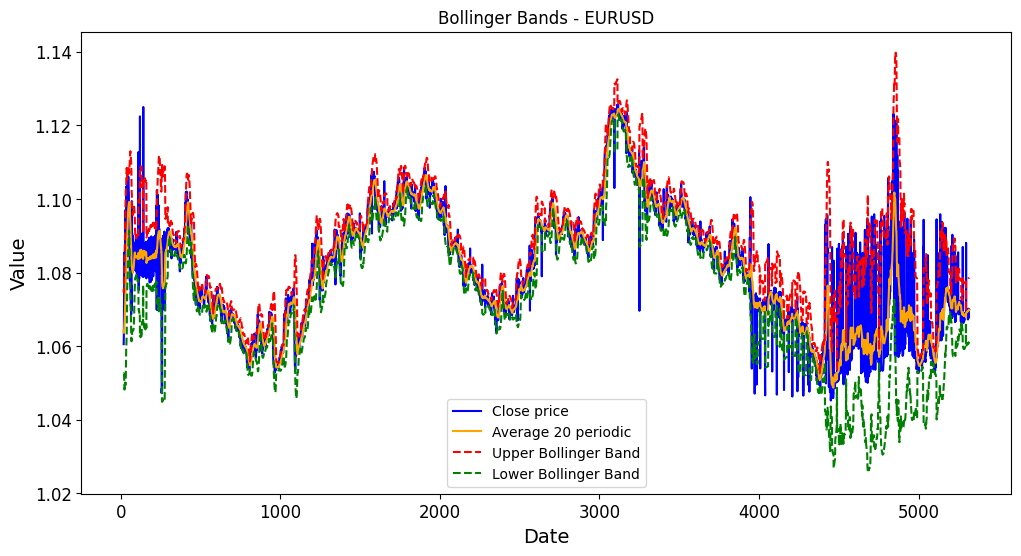

In [27]:
grouped = df.groupby('Name')

for name, group in grouped:
    plt.figure(figsize=(12, 6))
    plt.title(f'Bollinger Bands - {name}')
    
    plt.plot(group.index, group['Close'], label='Close price', color='blue') 
    plt.plot(group.index, group['B_MA'], label=f'Average {n} periodic', color='orange')  
    plt.plot(group.index, group['BU'], label=f'Upper Bollinger Band', color='red', linestyle='--') 
    plt.plot(group.index, group['BL'], label=f'Lower Bollinger Band', color='green', linestyle='--') 
   
    plt.legend()  
    plt.xlabel('Date') 
    plt.ylabel('Value') 
    plt.show()

In [28]:
df[['B_MA', 'BU', 'BL','Close']]

B_MA        BU        BL    Close
19    1.064059  1.075502  1.052616  1.06056
20    1.063649  1.074653  1.052646  1.06262
21    1.063734  1.074986  1.052481  1.07238
22    1.064398  1.077209  1.051587  1.07741
23    1.065230  1.081066  1.049393  1.08551
...        ...       ...       ...      ...
5313  1.069726  1.078503  1.060949  1.07016
5314  1.069785  1.078540  1.061030  1.06957
5315  1.069747  1.078533  1.060960  1.06769
5316  1.069823  1.078586  1.061060  1.06992
5317  1.069885  1.078631  1.061139  1.06991

[5299 rows x 4 columns]

## Export file

In [29]:
#df.to_csv("indicators_eurusd_d.csv", index=False, encoding='utf-8-sig')
df.to_csv("indicators_eurusd_d_1H.csv", index=False, encoding='utf-8-sig')
# df.to_csv("indicators_eurusd_d_5Y.csv", index=False, encoding='utf-8-sig')

## [References](#References)

***

# Fuzzyfication and backtesting

- **Start:** Data rozpoczęcia symulacji backtestu.
- **End:** Data zakończenia symulacji backtestu.
- **Duration:** Czas trwania symulacji backtestu.
- **Exposure Time [%]:** Procent czasu, w którym kapitał był inwestowany w rynku.
- **Equity Final [\$]:** Ostateczny kapitał na koniec symulacji.
- **Equity Peak [\$]:** Najwyższy osiągnięty poziom kapitału.
- **Return [%]:** Procentowy zwrot kapitału w trakcie symulacji.
- **Buy & Hold Return [%]:** Procentowy zwrot kapitału w przypadku strategii buy & hold.
- **Return (Ann.) [%]:** Procentowy zwrot kapitału na rok.
- **Volatility (Ann.) [%]:** Procentowa zmienność na rok.
- **Sharpe Ratio:** Wskaźnik Sharpe'a.
- **Sortino Ratio:** Wskaźnik Sortino.
- **Calmar Ratio:** Wskaźnik Calmara.
- **Max. Drawdown [%]:** Maksymalne obniżenie kapitału.
- **Avg. Drawdown [%]:** Średnie obniżenie kapitału.
- **Max. Drawdown Duration:** Okres trwania maksymalnego obniżenia kapitału.
- **Avg. Drawdown Duration:** Średni okres trwania obniżenia kapitału.
- **# Trades:** Liczba przeprowadzonych transakcji.
- **Win Rate [%]:** Procent transakcji z zyskiem.
- **Best Trade [%]:** Najlepszy zysk z pojedynczej transakcji.
- **Worst Trade [%]:** Najgorsza strata z pojedynczej transakcji.
- **Avg. Trade [%]:** Średni zysk lub strata z pojedynczej transakcji.
- **Max. Trade Duration:** Maksymalny czas trwania pojedynczej transakcji.
- **Avg. Trade Duration:** Średni czas trwania pojedynczej transakcji.
- **Profit Factor:** Wskaźnik zysku.
- **Expectancy [%]:** Oczekiwany zysk w każdej transakcji.
- **SQN:** System Quality Number.
- **Kelly Criterion:** Wskaźnik Kelly'ego.


set_trailing_sl - Ustawia przyszły trailing stop-loss jako pewną wielokrotność (n_atr) średnich rzeczywistych zakresów słupków od bieżącej ceny. [TrailingStrategy]
def next -> trade.sl() - Stop-loss price at which to close the trade. This variable is writable. By assigning it a new price value, you create or modify the existing SL order. By assigning it None, you cancel it.


***

In [31]:
df = pd.read_csv('indicators_eurusd_d_1H.csv')

In [132]:
# df = pd.read_csv('indicators_eurusd_d_5Y.csv')

In [32]:
df.head()

id    name     Open    Close     High      Low  data_volume   
0  41482  EURUSD  1.06074  1.06056  1.06083  1.05995          0.0  \
1  41512  EURUSD  1.06297  1.06262  1.06334  1.06122          0.0   
2  41537  EURUSD  1.07050  1.07238  1.07308  1.07030          0.0   
3  41562  EURUSD  1.07777  1.07741  1.07798  1.07608          0.0   
4  41592  EURUSD  1.08650  1.08551  1.08655  1.08546          0.0   

             data_datetime timeframe    Name  ...     12Ewm     26Ewm   
0  2023-03-16 06:00:00.000        1h  EURUSD  ...  1.064645  1.065467  \
1  2023-03-17 12:00:00.000        1h  EURUSD  ...  1.064334  1.065256   
2  2023-03-20 13:00:00.000        1h  EURUSD  ...  1.065572  1.065784   
3  2023-03-21 14:00:00.000        1h  EURUSD  ...  1.067393  1.066645   
4  2023-03-22 20:00:00.000        1h  EURUSD  ...  1.070180  1.068042   

       MACD   low_14  high_14  k_percent  r_percent      B_MA        BU   
0 -0.000822  1.05425  1.07463  30.961727 -69.038273  1.064059  1.075502  \
1 -0.000922  1.05425  1.07463  41.069676 -58.930324  1.063649  1.074653   
2 -0.000212  1.05425  1.07463  88.959764 -11.040236  1.063734  1.074986   
3  0.000748  1.05425  1.07798  97.597977  -2.402023  1.064398  1.077209   
4  0.002138  1.05425  1.08655  96.780186  -3.219814  1.065230  1.081066   

         BL  
0  1.052616  
1  1.052646  
2  1.052481  
3  1.051587  
4  1.049393  

[5 rows x 29 columns]

## RSI decision


In [33]:
data = df

In [34]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] <= 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] >= 70, 'dec_rsi'] = 'SELL'

    return df

In [35]:
decision_rsi(data)
data['dec_rsi'].value_counts()

dec_rsi
HOLD    4131
BUY      610
SELL     558
Name: count, dtype: int64

In [36]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[50, 1.], [51, 1.], [61, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[61, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)

# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS BUY)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS SELL)"
FS.add_rules([R1, R2, R3])

data['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



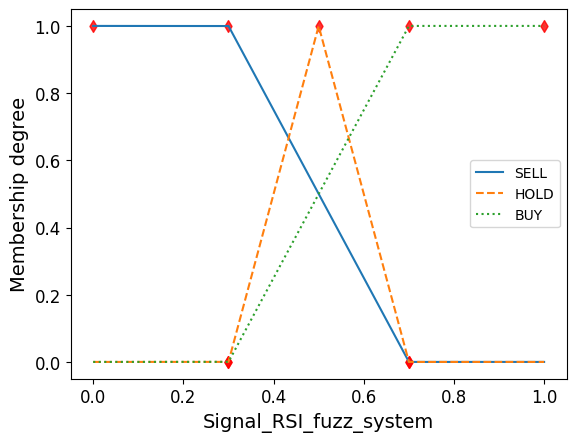

In [37]:
FS.plot_variable('Signal_RSI_fuzz_system')

In [38]:
data['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    3837
SELL     790
BUY      672
Name: count, dtype: int64

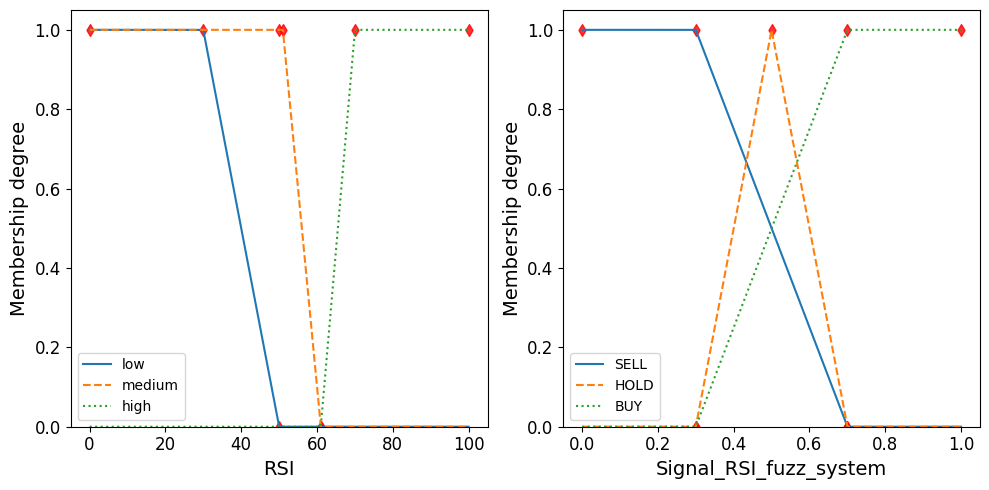

In [39]:
FS.produce_figure('Signal_RSI_fuzz_system')

## RSI backtesting

In [40]:
# zmiana na datę i ustaw jako index
# data = data.set_index(pd.DatetimeIndex(data['Date']))
# zmiana decyzji na -1, 0, 1
data['dec_rsi'] = data['dec_rsi'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

* sl = Cena stop-loss, po której, jeśli zostanie ustawiona, nowe warunkowe zlecenie stop-market zostanie złożone dla transakcji następującej po realizacji tego zlecenia. Zobacz także Trade.sl.
* Trade.sl = Cena stop-loss, po której należy zamknąć transakcję. Ta zmienna jest zapisywalna. Przypisując jej nową wartość ceny, tworzysz lub modyfikujesz istniejące zlecenie SL. Przypisanie wartości None oznacza jego anulowanie.
* trade_on_close = True - zlecenia rynkowe wypełniane w odniesieniu do ceny zamknięcia bieżącego słupka zamiast
* hedging = True - transakcje w obu kierunkach
* exclusive_orders = True - każde nowe zlecenie automatycznie zamyka poprzednią transakcję/pozycję

## Sharp

In [41]:
class CustomStrategy(SignalStrategy):
    
    price_delta = 0.015 # różnica w cenie
    risk_per_trade = 0.08  # ryzyko x% kapitału na jedną transakcję
    fixed_size = 0.7  # Stała wielkość transakcji
    
    def init(self):
        super().init()
        self.rsi = self.I(lambda x: data['dec_rsi'], 'rsi')

    def next(self):
        close = self.data.Close[-1]
        signal = self.rsi[-1] 

        upper, lower = close * (1 + np.r_[1, -1] * self.price_delta)  # price_delta * 100% różnicy pomiędzy ceną zamknięcia 
        
        adaptive_risk = self.risk_per_trade / close  
        capital_at_risk = adaptive_risk * self._broker._cash
        
        # Stała wielkość transakcji w przedziale [0, 1]
        size_transaction = max(min(self.fixed_size, 1), 0) 
        
        if not self.position:
            if signal == 1 and self._broker._cash == 10000: 
                self.buy(size=size_transaction)
        elif self.position:    
            if signal == 1 and not self.position.is_long:
                self.buy(size=size_transaction)
            elif signal == -1:
                self.sell(size=size_transaction)
                
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, 
              trade_on_close=False, hedging=False, exclusive_orders=True)
stats = bt.run()
bt.plot()
stats


Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                   99.282884
Equity Final [$]                  4204.814952
Equity Peak [$]                  10251.796617
Return [%]                          -57.95185
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -59.051373
Avg. Drawdown [%]                  -13.319428
Max. Drawdown Duration                 5175.0
Avg. Drawdown Duration                 1052.2
# Trades                                636.0
Win Rate [%]                        13.207547
Best Trade [%]                       3.465211
Worst Trade [%]                     -4.005948
Avg. Trade [%]                    

In [42]:
data['Signal_RSI_fuzz_system'] = data['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    
    price_delta = 0.02 # różnica w cenie
    fixed_size = 0.7  # Stała wielkość transakcji
    
    def init(self):
        super().init()
        self.rsi = self.I(lambda x: data['Signal_RSI_fuzz_system'], 'rsi')

    def next(self):
        close = self.data.Close[-1]
        signal = self.rsi[-1] 

        upper, lower = close * (1 + np.r_[1, -1] * self.price_delta)  # price_delta * 100% różnicy pomiędzy ceną zamknięcia 
        

        size_transaction = self.fixed_size
        
        if not self.position:
            if signal == 1 and self._broker._cash == 10000: 
                self.buy(size=size_transaction)
        elif self.position:    
            if signal == 1 and not self.position.is_long:
                self.buy(size=size_transaction)
            elif signal == -1:
                self.sell(size=size_transaction)
                
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, 
              trade_on_close=False, hedging=False, exclusive_orders=False)
stats = bt.run()
bt.plot()
stats


Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                   99.282884
Equity Final [$]                 10168.680823
Equity Peak [$]                  10474.447655
Return [%]                           1.686808
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -7.88543
Avg. Drawdown [%]                   -1.413892
Max. Drawdown Duration                 2861.0
Avg. Drawdown Duration             181.137931
# Trades                                199.0
Win Rate [%]                         60.80402
Best Trade [%]                       3.143903
Worst Trade [%]                     -2.803131
Avg. Trade [%]                    

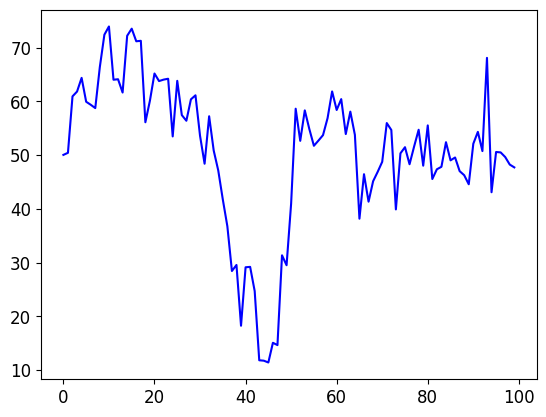

In [43]:

plt.plot(data.iloc[0:100].index, data['RSI'].iloc[0:100], color='blue')


In [145]:
data.columns.tolist()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Name',
 'Return',
 'Up',
 'Down',
 'avg_14up',
 'avg_14down',
 'RS_14',
 'RSI',
 '5MA',
 '15MA',
 '12Ewm',
 '26Ewm',
 'MACD',
 'low_14',
 'high_14',
 'k_percent',
 'r_percent',
 'B_MA',
 'BU',
 'BL',
 'dec_rsi',
 'Signal_RSI_fuzz_system']

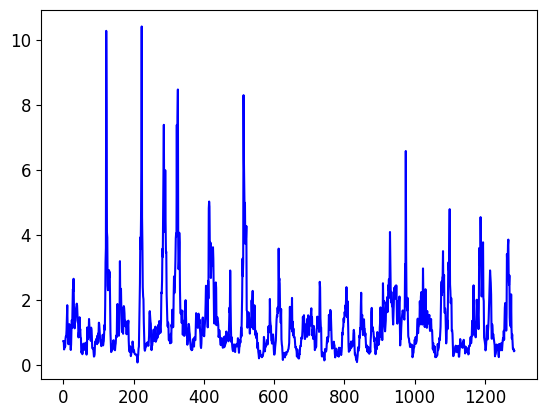

In [146]:
plt.plot(data.index, data['RS_14'], color='blue')


In [147]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['dec_rsi'])

#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=True, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    1284.0
Duration                               1284.0
Exposure Time [%]                   95.953307
Equity Final [$]                  9999.262339
Equity Peak [$]                       10000.0
Return [%]                          -0.007377
Buy & Hold Return [%]               -3.989744
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.007565
Avg. Drawdown [%]                   -0.007565
Max. Drawdown Duration                 1233.0
Avg. Drawdown Duration                 1233.0
# Trades                                304.0
Win Rate [%]                        25.657895
Best Trade [%]                       4.956159
Worst Trade [%]                     -3.242226
Avg. Trade [%]                    

## Fuzzy

In [148]:
data['Signal_RSI_fuzz_system'] = data['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy, TrailingStrategy, Strategy):
    def init(self):
        super().init()
        self.set_signal(data['Signal_RSI_fuzz_system'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    1284.0
Duration                               1284.0
Exposure Time [%]                   95.564202
Equity Final [$]                  9996.687916
Equity Peak [$]                  10000.672178
Return [%]                          -0.033121
Buy & Hold Return [%]               -3.989744
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.051019
Avg. Drawdown [%]                   -0.009145
Max. Drawdown Duration                 1061.0
Avg. Drawdown Duration             208.333333
# Trades                                272.0
Win Rate [%]                        39.705882
Best Trade [%]                       7.079299
Worst Trade [%]                     -6.385485
Avg. Trade [%]                    

# Williams %R ('r_percent')


In [44]:
def decision_williams(df):
    df['dec_will'] = 'HOLD'  

    # -80 (oversold), sets decision to 'BUY'
    df.loc[df['r_percent'] <= -80, 'dec_will'] = 'BUY'
    # -20 (overbought), sets decision to 'SELL'
    df.loc[df['r_percent'] >= -20, 'dec_will'] = 'SELL'

    return df



In [45]:
decision_williams(data)
data['dec_will'].value_counts()

dec_will
HOLD    2405
BUY     1621
SELL    1273
Name: count, dtype: int64

In [46]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-100, 1.], [-80, 1.], [-50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-50, 1.], [-49, 1.], [-39, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[-39, 0.], [-20, 1.], [0, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-100, 0])
FS.add_linguistic_variable("r_percent", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])

# S1 = sf.FuzzySet(points=[[0, 1.], [0.4, 1.], [0.6, 0.]], term="SELL")
# S2 = sf.FuzzySet(points=[[0.4, 0.], [0.5, 1.], [0.6, 0.]], term="HOLD")
# S3 = sf.FuzzySet(points=[[0.4, 0.], [0.6, 1.], [1.0, 1.]], term="BUY")
# LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_william_fuzz_system", LV)


R1 = "IF (r_percent IS low) THEN (Signal_william_fuzz_system IS BUY)"
R2 = "IF (r_percent IS medium) THEN (Signal_william_fuzz_system IS HOLD)"
R3 = "IF (r_percent IS high) THEN (Signal_william_fuzz_system IS SELL)"
FS.add_rules([R1, R2, R3])

data['Signal_william_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['r_percent']):
    FS.set_variable("r_percent", value)
    decision = FS.Mamdani_inference()['Signal_william_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [47]:
data['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
HOLD    1878
SELL    1712
BUY     1709
Name: count, dtype: int64

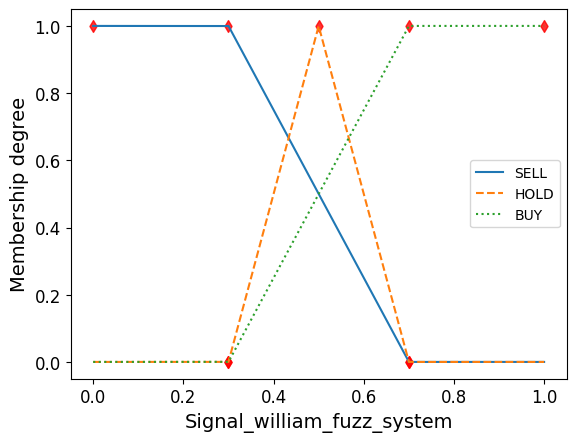

In [48]:
FS.plot_variable('Signal_william_fuzz_system')

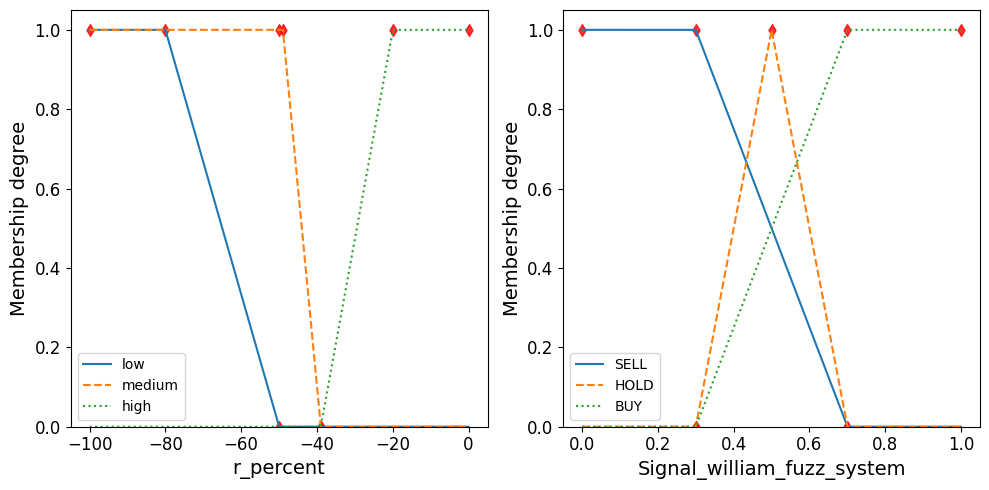

In [49]:
FS.produce_figure('Signal_william_fuzz_system')

# Williams backtesting

In [50]:
data['dec_will'] = data['dec_will'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})



class CustomStrategy(SignalStrategy):
    
    price_delta = 0.015 # róznica w cenie
    risk_per_trade = 0.08  # ryzyko x% kapitału na jedną transakcję
    
    def init(self):
        super().init()
        self.rsi = self.I(lambda x: data['dec_will'], 'williams')

        

    def next(self):
        close = self.data.Close[-1]
        signal = self.rsi[-1] 

        
        upper, lower = close * (1 + np.r_[1, -1]*self.price_delta) # price_delta * 100% różnicy pomiędzy ceną zamknięcia 
        
        adaptive_risk = self.risk_per_trade  / close  
        capital_at_risk = adaptive_risk * self._broker._cash
        size_transaction = (capital_at_risk / self._broker._cash)   
        size_transaction += random.uniform(0.09, 0.4)

        if not self.position:
            if signal == 1 and self._broker._cash == 10000: # Pierwsza transakcja ma być jako kupno
                self.buy(size = 0.8)
#                 print("First BUY")         
        elif self.position:    
            if signal == 1 and not self.position.is_long:
#                 self.buy(size = size_transaction, sl = lower, tp = upper)
                 self.buy(size = size_transaction, tp = upper)

#                 print("BUY in else")
#                 print(f"Size 2 {size_transaction}")

            elif signal == -1:# and self.position.is_long:
#                 self.sell(size = size_transaction, tp = lower, sl = upper)
                 self.sell(size = size_transaction, sl = upper)

  

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, 
              trade_on_close = False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats
     
  


Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                    1.132289
Equity Final [$]                 10022.196962
Equity Peak [$]                  10030.412541
Return [%]                            0.22197
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.946967
Avg. Drawdown [%]                   -1.433141
Max. Drawdown Duration                 5247.0
Avg. Drawdown Duration                 2632.5
# Trades                                  5.0
Win Rate [%]                             60.0
Best Trade [%]                       2.227341
Worst Trade [%]                     -0.596761
Avg. Trade [%]                    

In [51]:
data['Signal_william_fuzz_system'] = data['Signal_william_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})



class CustomStrategy(SignalStrategy):
    
    price_delta = 0.015 # róznica w cenie
    risk_per_trade = 0.08  # ryzyko x% kapitału na jedną transakcję
    
    def init(self):
        super().init()
        self.rsi = self.I(lambda x: data['Signal_william_fuzz_system'], 'williams')

        

    def next(self):
        close = self.data.Close[-1]
        signal = self.rsi[-1] 

        
        upper, lower = close * (1 + np.r_[1, -1]*self.price_delta) # price_delta * 100% różnicy pomiędzy ceną zamknięcia 
        
        adaptive_risk = self.risk_per_trade  / close  
        capital_at_risk = adaptive_risk * self._broker._cash
        size_transaction = (capital_at_risk / self._broker._cash)   
        size_transaction += random.uniform(0.09, 0.4)

        if not self.position:
            if signal == 1 and self._broker._cash == 10000: # Pierwsza transakcja ma być jako kupno
                self.buy(size = 0.8)
#                 print("First BUY")         
        elif self.position:    
            if signal == 1 and not self.position.is_long:
#                 self.buy(size = size_transaction, sl = lower, tp = upper)
                 self.buy(size = size_transaction, tp = upper)

#                 print("BUY in else")
#                 print(f"Size 2 {size_transaction}")

            elif signal == -1:# and self.position.is_long:
#                 self.sell(size = size_transaction, tp = lower, sl = upper)
                 self.sell(size = size_transaction, sl = upper)

  

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, 
              trade_on_close = False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats
     
  


Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                    1.132289
Equity Final [$]                 10013.922498
Equity Peak [$]                  10030.412541
Return [%]                           0.139225
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.946967
Avg. Drawdown [%]                   -1.442299
Max. Drawdown Duration                 5247.0
Avg. Drawdown Duration                 2632.5
# Trades                                  7.0
Win Rate [%]                        57.142857
Best Trade [%]                       2.227341
Worst Trade [%]                     -0.596761
Avg. Trade [%]                    

In [52]:
data.head()

id    name     Open    Close     High      Low  data_volume   
0  41482  EURUSD  1.06074  1.06056  1.06083  1.05995          0.0  \
1  41512  EURUSD  1.06297  1.06262  1.06334  1.06122          0.0   
2  41537  EURUSD  1.07050  1.07238  1.07308  1.07030          0.0   
3  41562  EURUSD  1.07777  1.07741  1.07798  1.07608          0.0   
4  41592  EURUSD  1.08650  1.08551  1.08655  1.08546          0.0   

             data_datetime timeframe    Name  ...  high_14  k_percent   
0  2023-03-16 06:00:00.000        1h  EURUSD  ...  1.07463  30.961727  \
1  2023-03-17 12:00:00.000        1h  EURUSD  ...  1.07463  41.069676   
2  2023-03-20 13:00:00.000        1h  EURUSD  ...  1.07463  88.959764   
3  2023-03-21 14:00:00.000        1h  EURUSD  ...  1.07798  97.597977   
4  2023-03-22 20:00:00.000        1h  EURUSD  ...  1.08655  96.780186   

   r_percent      B_MA        BU        BL  dec_rsi  Signal_RSI_fuzz_system   
0 -69.038273  1.064059  1.075502  1.052616        0                       0  \
1 -58.930324  1.063649  1.074653  1.052646        0                       0   
2 -11.040236  1.063734  1.074986  1.052481        0                       0   
3  -2.402023  1.064398  1.077209  1.051587        0                       0   
4  -3.219814  1.065230  1.081066  1.049393        0                       0   

   dec_will  Signal_william_fuzz_system  
0         0                           0  
1         0                           0  
2        -1                          -1  
3        -1                          -1  
4        -1                          -1  

[5 rows x 33 columns]

### Sharp

In [157]:
# zmiana decyzji na -1, 0, 1
data['dec_will'] = data['dec_will'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        
        self.set_signal(data['dec_will'])
      

        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    1284.0
Duration                               1284.0
Exposure Time [%]                   98.677043
Equity Final [$]                 10004.910636
Equity Peak [$]                   10005.52374
Return [%]                           0.049106
Buy & Hold Return [%]               -3.989744
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.021978
Avg. Drawdown [%]                   -0.002339
Max. Drawdown Duration                  119.0
Avg. Drawdown Duration              17.070423
# Trades                                262.0
Win Rate [%]                        70.610687
Best Trade [%]                       11.56764
Worst Trade [%]                     -6.350396
Avg. Trade [%]                    

### Fuzzy

In [158]:
data['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
 0    631
-1    357
 1    297
Name: count, dtype: int64

In [159]:
data['Signal_william_fuzz_system'] = data['Signal_william_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['Signal_william_fuzz_system'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    1284.0
Duration                               1284.0
Exposure Time [%]                   98.599222
Equity Final [$]                 10008.170386
Equity Peak [$]                  10010.968837
Return [%]                           0.081704
Buy & Hold Return [%]               -3.989744
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.063308
Avg. Drawdown [%]                   -0.004823
Max. Drawdown Duration                  395.0
Avg. Drawdown Duration              20.116667
# Trades                                356.0
Win Rate [%]                        67.134831
Best Trade [%]                      15.499366
Worst Trade [%]                     -11.22068
Avg. Trade [%]                    

# MA decision



kupno - krótsza przecina dłuższą od dołu 

sprzedaż - krótsza przecina dłuższą od góry


In [53]:
# Ostre

data['prev_5MA'] = data['5MA'].shift(1)

data['crossover'] = np.where((data['5MA'] > data['15MA']) & (data['prev_5MA'] < data['15MA']), 'bullish crossover',
                                  np.where((data['5MA'] < data['15MA']) & (data['prev_5MA'] > data['15MA']), 'bearish crossover', None))

data['cross_MA'] = np.where(data['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(data['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))

data['crossover'].value_counts()



crossover
bullish crossover    303
bearish crossover    269
Name: count, dtype: int64

In [54]:
data['cross_MA'].value_counts()

cross_MA
HOLD    4727
BUY      303
SELL     269
Name: count, dtype: int64

In [55]:
# Calculating the difference between the shorter and longer average

data['diff_MA'] = data['5MA'] - data['15MA']

# Creation of 1 lagged column with difference in averages
data['diff_MA_prev'] = data['diff_MA'].shift(1)

data['diff_MA'].describe()

count    5299.000000
mean        0.000007
std         0.002944
min        -0.020712
25%        -0.001129
50%         0.000005
75%         0.001074
max         0.018701
Name: diff_MA, dtype: float64

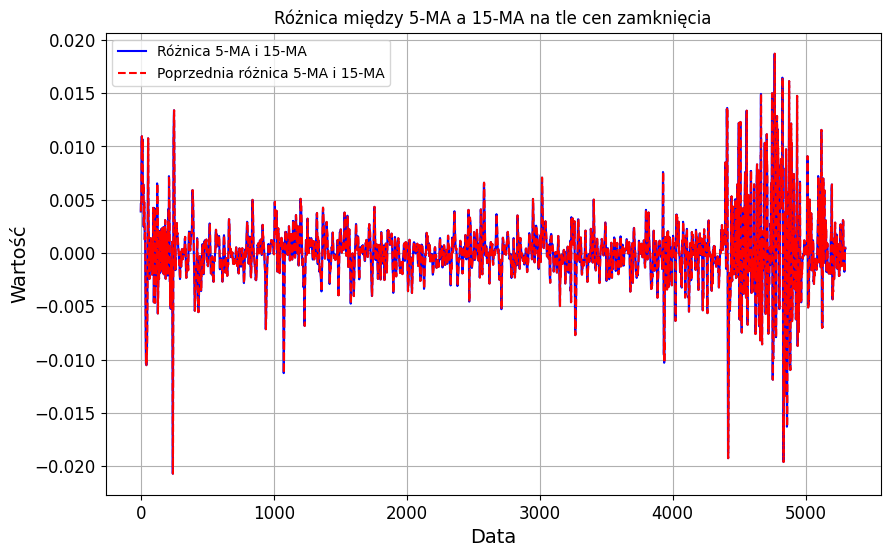

In [56]:
plt.figure(figsize=(10, 6))

# plt.plot(data.index, data['Close'], label='Ceny zamknięcia', color='black')

plt.plot(data.index, data['diff_MA'], label='Różnica 5-MA i 15-MA', color='blue')

plt.plot(data.index, data['diff_MA_prev'], label='Poprzednia różnica 5-MA i 15-MA', color='red', linestyle='dashed')

plt.legend()

plt.title('Różnica między 5-MA a 15-MA na tle cen zamknięcia')
plt.xlabel('Data')
plt.ylabel('Wartość')

plt.grid(True)
plt.show()


In [57]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)
FS.add_linguistic_variable("diff_MA_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])


FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS medium) AND (diff_MA_prev IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS medium) AND (diff_MA_prev IS high) THEN (fuzz_MA_strategy IS SELL)"
R3 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS HOLD)"
R4 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", data.loc[data.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [58]:
data['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
HOLD    5145
SELL      82
BUY       72
Name: count, dtype: int64

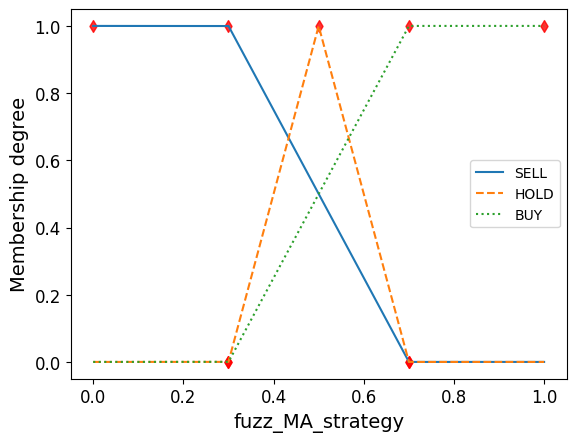

In [166]:
FS.plot_variable('fuzz_MA_strategy')

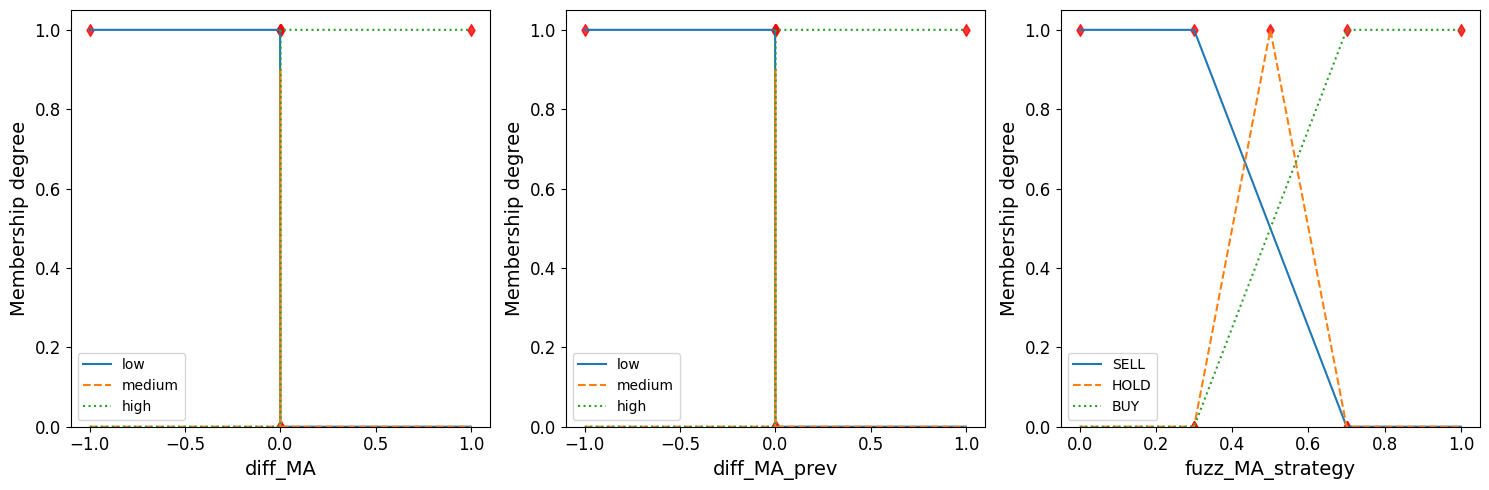

In [167]:
FS.produce_figure('fuzz_MA_strategy')

# MA backtesting

## Sharp

In [59]:
data['cross_MA'] = data['cross_MA'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['cross_MA'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                   95.886016
Equity Final [$]                  9998.821118
Equity Peak [$]                  10000.687498
Return [%]                          -0.011789
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.022739
Avg. Drawdown [%]                   -0.001732
Max. Drawdown Duration                 2200.0
Avg. Drawdown Duration             180.137931
# Trades                                303.0
Win Rate [%]                        40.594059
Best Trade [%]                       5.297975
Worst Trade [%]                     -4.011657
Avg. Trade [%]                    

## Fuzzy

In [60]:
data['fuzz_MA_strategy'] = data['fuzz_MA_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_MA_strategy'])
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                   98.056237
Equity Final [$]                   9999.66123
Equity Peak [$]                  10000.121633
Return [%]                          -0.003388
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.007634
Avg. Drawdown [%]                   -0.002418
Max. Drawdown Duration                 3232.0
Avg. Drawdown Duration                  523.0
# Trades                                 82.0
Win Rate [%]                        35.365854
Best Trade [%]                       3.090287
Worst Trade [%]                     -4.425464
Avg. Trade [%]                    

# MACD decision

In [62]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''
    
data['Signal_Line'] = data.groupby('Name')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

buy_condition = ((data['MACD'].shift(1) < data['Signal_Line'].shift(1)) & 
                 (data['MACD'] > data['Signal_Line']))  
               

sell_condition = ((data['MACD'].shift(1) > data['Signal_Line'].shift(1)) & 
                  (data['MACD'] < data['Signal_Line']))

data['MACD_decision'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))

data[['MACD', 'Signal_Line']].describe()

MACD  Signal_Line
count  5299.000000  5299.000000
mean      0.000004     0.000003
std       0.001562     0.001368
min      -0.009700    -0.005814
25%      -0.000846    -0.000778
50%      -0.000088    -0.000095
75%       0.000723     0.000689
max       0.010653     0.008690

In [63]:
# Calculating the difference between MACD and Signal line
data['diff_MACD'] = data['MACD'] - data['Signal_Line']

# Creation of 1 lagged column with the difference in MACD and Signal
data['diff_MACD_prev'] = data['diff_MACD'].shift(1)

In [67]:
data['diff_MACD'].describe().round(5)

count    5299.00000
mean        0.00000
std         0.00068
min        -0.00594
25%        -0.00026
50%         0.00002
75%         0.00026
max         0.00453
Name: diff_MACD, dtype: float64

In [68]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MACD około 0 (0,001) i diff_MACD_prev < 0 - BUY
Jeśli diff_MACD około 0(0,001) i diff_MACD_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MACD", LV)
FS.add_linguistic_variable("diff_MACD_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MACD_strategy", LV)

R1 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS low) THEN (fuzz_MACD_strategy IS BUY)"
R2 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS high) THEN (fuzz_MACD_strategy IS SELL)"
R3 = "IF (diff_MACD IS low) THEN (fuzz_MACD_strategy IS HOLD)"
R4 = "IF (diff_MACD IS high) THEN (fuzz_MACD_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MACD_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MACD']):
    FS.set_variable("diff_MACD", value)
    FS.set_variable("diff_MACD_prev", data.loc[data.index[i], 'diff_MACD_prev'])
    decision = FS.Mamdani_inference()['fuzz_MACD_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



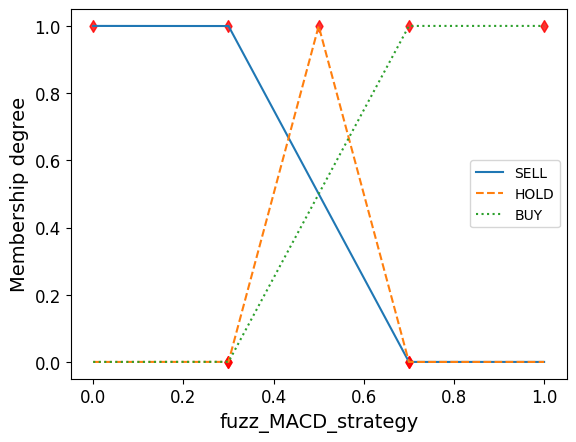

In [69]:
FS.plot_variable('fuzz_MACD_strategy')

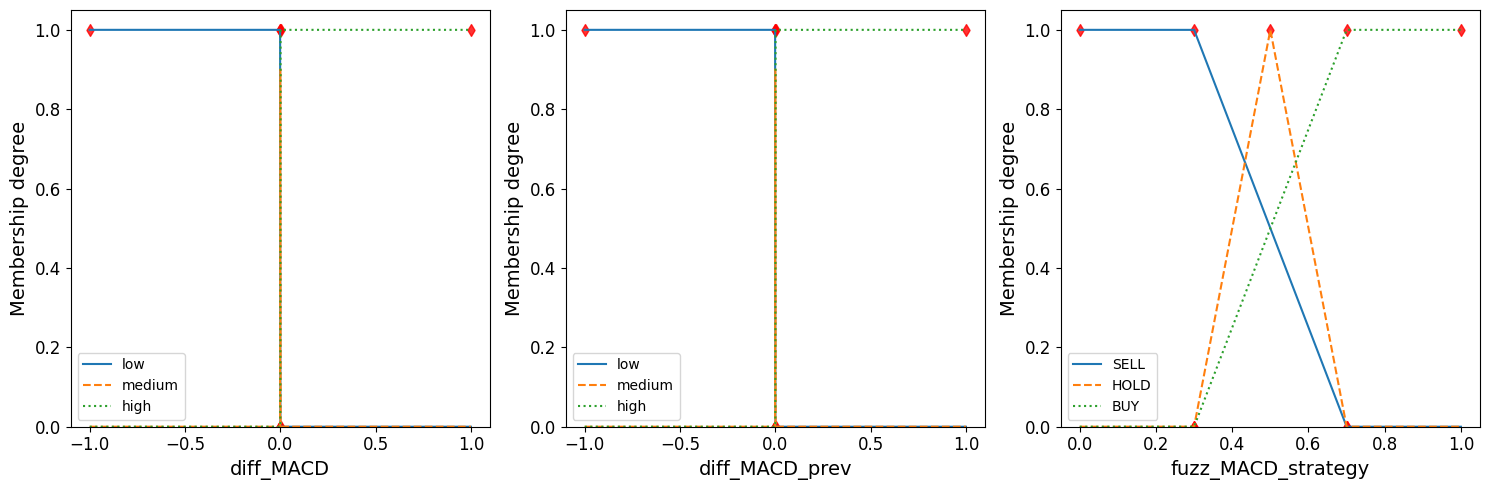

In [175]:
FS.produce_figure('fuzz_MACD_strategy')

# MACD backtesting

### Sharp

In [70]:
data['MACD_decision'] = data['MACD_decision'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


In [71]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['MACD_decision'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                   53.293074
Equity Final [$]                  9998.992563
Equity Peak [$]                  10000.030358
Return [%]                          -0.010074
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.010546
Avg. Drawdown [%]                   -0.002671
Max. Drawdown Duration                 5251.0
Avg. Drawdown Duration                 1315.5
# Trades                                262.0
Win Rate [%]                        24.045802
Best Trade [%]                       2.780474
Worst Trade [%]                     -4.402085
Avg. Trade [%]                    

### Fuzzy

In [72]:
data['fuzz_MACD_strategy'] = data['fuzz_MACD_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_MACD_strategy'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
#bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    5298.0
Duration                               5298.0
Exposure Time [%]                   99.603699
Equity Final [$]                   9999.47448
Equity Peak [$]                  10000.118984
Return [%]                          -0.005255
Buy & Hold Return [%]                 0.88161
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.017893
Avg. Drawdown [%]                   -0.004711
Max. Drawdown Duration                 4730.0
Avg. Drawdown Duration             478.909091
# Trades                                 48.0
Win Rate [%]                             12.5
Best Trade [%]                       1.726177
Worst Trade [%]                      -3.62514
Avg. Trade [%]                    

## [References](#References)

# Bollinger Bands decision

### Sharp

In [73]:
   '''
   'B_MA',
 'BU',
 'BL',
    close < BL - kup
    close > BU - sprzedaj
    '''
def decision_bollinger(df):
    df['dec_bollinger'] = 'HOLD'  

    df.loc[df['Close'] < df['BL'], 'dec_bollinger'] = 'BUY'
    df.loc[df['Close'] > df['BU'], 'dec_bollinger'] = 'SELL'

    return df

In [74]:
decision_bollinger(data)

id    name     Open    Close     High      Low  data_volume   
0     41482  EURUSD  1.06074  1.06056  1.06083  1.05995          0.0  \
1     41512  EURUSD  1.06297  1.06262  1.06334  1.06122          0.0   
2     41537  EURUSD  1.07050  1.07238  1.07308  1.07030          0.0   
3     41562  EURUSD  1.07777  1.07741  1.07798  1.07608          0.0   
4     41592  EURUSD  1.08650  1.08551  1.08655  1.08546          0.0   
...     ...     ...      ...      ...      ...      ...          ...   
5294  67712  EURUSD  1.06960  1.07016  1.07051  1.06901          0.0   
5295  67702  EURUSD  1.06991  1.06957  1.07061  1.06936          0.0   
5296  67682  EURUSD  1.06730  1.06769  1.06801  1.06679          0.0   
5297  67698  EURUSD  1.06888  1.06992  1.07038  1.06852          0.0   
5298  67724  EURUSD  1.07018  1.06991  1.07043  1.06991          0.0   

                data_datetime timeframe    Name  ...  cross_MA   diff_MA   
0     2023-03-16 06:00:00.000        1h  EURUSD  ...         0  0.003894  \
1     2023-03-17 12:00:00.000        1h  EURUSD  ...         0  0.004652   
2     2023-03-20 13:00:00.000        1h  EURUSD  ...         0  0.004552   
3     2023-03-21 14:00:00.000        1h  EURUSD  ...         0  0.004509   
4     2023-03-22 20:00:00.000        1h  EURUSD  ...         0  0.005043   
...                       ...       ...     ...  ...       ...       ...   
5294  2023-11-13 18:00:00.000        1h  EURUSD  ...         0 -0.000080   
5295  2023-11-13 17:00:00.000        1h  EURUSD  ...         1  0.000353   
5296  2023-11-13 14:00:00.000        1h  EURUSD  ...         0  0.000480   
5297  2023-11-13 16:00:00.000        1h  EURUSD  ...         0  0.000338   
5298  2023-11-13 20:00:00.000        1h  EURUSD  ...         0  0.000497   

      diff_MA_prev  fuzz_MA_strategy  Signal_Line  MACD_decision  diff_MACD   
0              NaN                 0    -0.000822              0   0.000000  \
1         0.003894                 0    -0.000842              0  -0.000081   
2         0.004652                 0    -0.000716              1   0.000504   
3         0.004552                 0    -0.000423              0   0.001171   
4         0.004509                 0     0.000089              0   0.002049   
...            ...               ...          ...            ...        ...   
5294     -0.001562                 1    -0.000055              0  -0.000015   
5295     -0.000080                 0    -0.000050              1   0.000021   
5296      0.000353                 0    -0.000069             -1  -0.000078   
5297      0.000480                 0    -0.000067              1   0.000007   
5298      0.000338                 0    -0.000052              0   0.000060   

      diff_MACD_prev  fuzz_MACD_strategy  dec_bollinger  
0                NaN                  -1           HOLD  
1           0.000000                   0           HOLD  
2          -0.000081                   0           HOLD  
3           0.000504                   0           SELL  
4           0.001171                   0           SELL  
...              ...                 ...            ...  
5294       -0.000128                   0           HOLD  
5295       -0.000015                   0           HOLD  
5296        0.000021                   0           HOLD  
5297       -0.000078                   0           HOLD  
5298        0.000007                   0           HOLD  

[5299 rows x 45 columns]

In [75]:
data['dec_bollinger'].value_counts()

dec_bollinger
HOLD    4712
SELL     317
BUY      270
Name: count, dtype: int64

### Fuzzy

In [76]:
'''
    diff_cl_BL < 0 - kup
    diff_cl_BU > 0 - sprzedaj
'''

data['diff_cl_BU'] = data['Close'] - data['BU']
data['diff_cl_BL'] = data['Close'] - data['BL']

data['prev_diff_cl_BU'] = data['diff_cl_BU'].shift(1)
data['prev_diff_cl_BL'] = data['diff_cl_BL'].shift(1)


In [77]:
data[['diff_cl_BU', 'diff_cl_BL']].describe()

diff_cl_BU   diff_cl_BL
count  5299.000000  5299.000000
mean     -0.007490     0.007508
std       0.009752     0.009552
min      -0.078191    -0.017391
25%      -0.008996     0.001920
50%      -0.004213     0.004209
75%      -0.001883     0.009779
max       0.019374     0.075826

In [78]:
# Fuzzy System initialization
FS = sf.FuzzySystem()

# Define linguistic variables for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [0, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[0, 0.], [0, 1.], [0, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_cl_BU", LV)
FS.add_linguistic_variable("diff_cl_BL", LV)
FS.add_linguistic_variable("prev_diff_cl_BU", LV)
FS.add_linguistic_variable("prev_diff_cl_BL", LV)

# Define linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_BB_strategy", LV)

# Define fuzzy rules

R1 = "IF (diff_cl_BU IS medium) AND (prev_diff_cl_BU IS low) THEN (fuzz_BB_strategy IS SELL)"
R2 = "IF (diff_cl_BU IS high) AND (NOT (diff_cl_BU IS low)) THEN (fuzz_BB_strategy IS SELL)"

R3 = "IF (diff_cl_BL IS medium) AND (prev_diff_cl_BL IS low) THEN (fuzz_BB_strategy IS BUY)"
R4 = "IF (diff_cl_BL IS low) AND (prev_diff_cl_BL IS low) THEN (fuzz_BB_strategy IS BUY)"

R5 = "IF (diff_cl_BU IS low) THEN (fuzz_BB_strategy IS HOLD)"
R6 = "IF (diff_cl_BL IS high) THEN (fuzz_BB_strategy IS HOLD)"


FS.add_rules([R1, R2, R3, R4, R5, R6])


# Initialize fuzzy MACD strategy column
data['fuzz_BB_strategy'] = 'HOLD'

# Perform fuzzy inference and generate signals
for i, row in data.iterrows():
    diff_cl_BU = row['diff_cl_BU']
    diff_cl_BU_prev = row['prev_diff_cl_BU']
    diff_cl_BL = row['diff_cl_BL']
    diff_cl_BL_prev = row['prev_diff_cl_BL']

    FS.set_variable("diff_cl_BU", diff_cl_BU)
    FS.set_variable("prev_diff_cl_BU", diff_cl_BU_prev)
    FS.set_variable("diff_cl_BL", diff_cl_BL)
    FS.set_variable("prev_diff_cl_BL", diff_cl_BL_prev)

    decision = FS.Mamdani_inference()['fuzz_BB_strategy']
    if decision >= 0.7:
        data.at[i, 'fuzz_BB_strategy'] = 'BUY'
    elif decision <= 0.3:
        data.at[i, 'fuzz_BB_strategy'] = 'SELL'


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



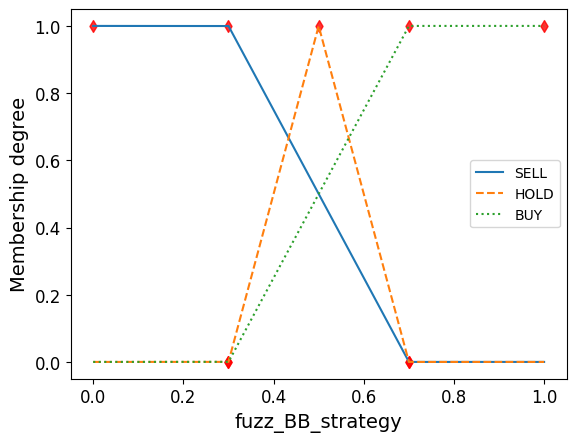

In [79]:
FS.plot_variable('fuzz_BB_strategy')

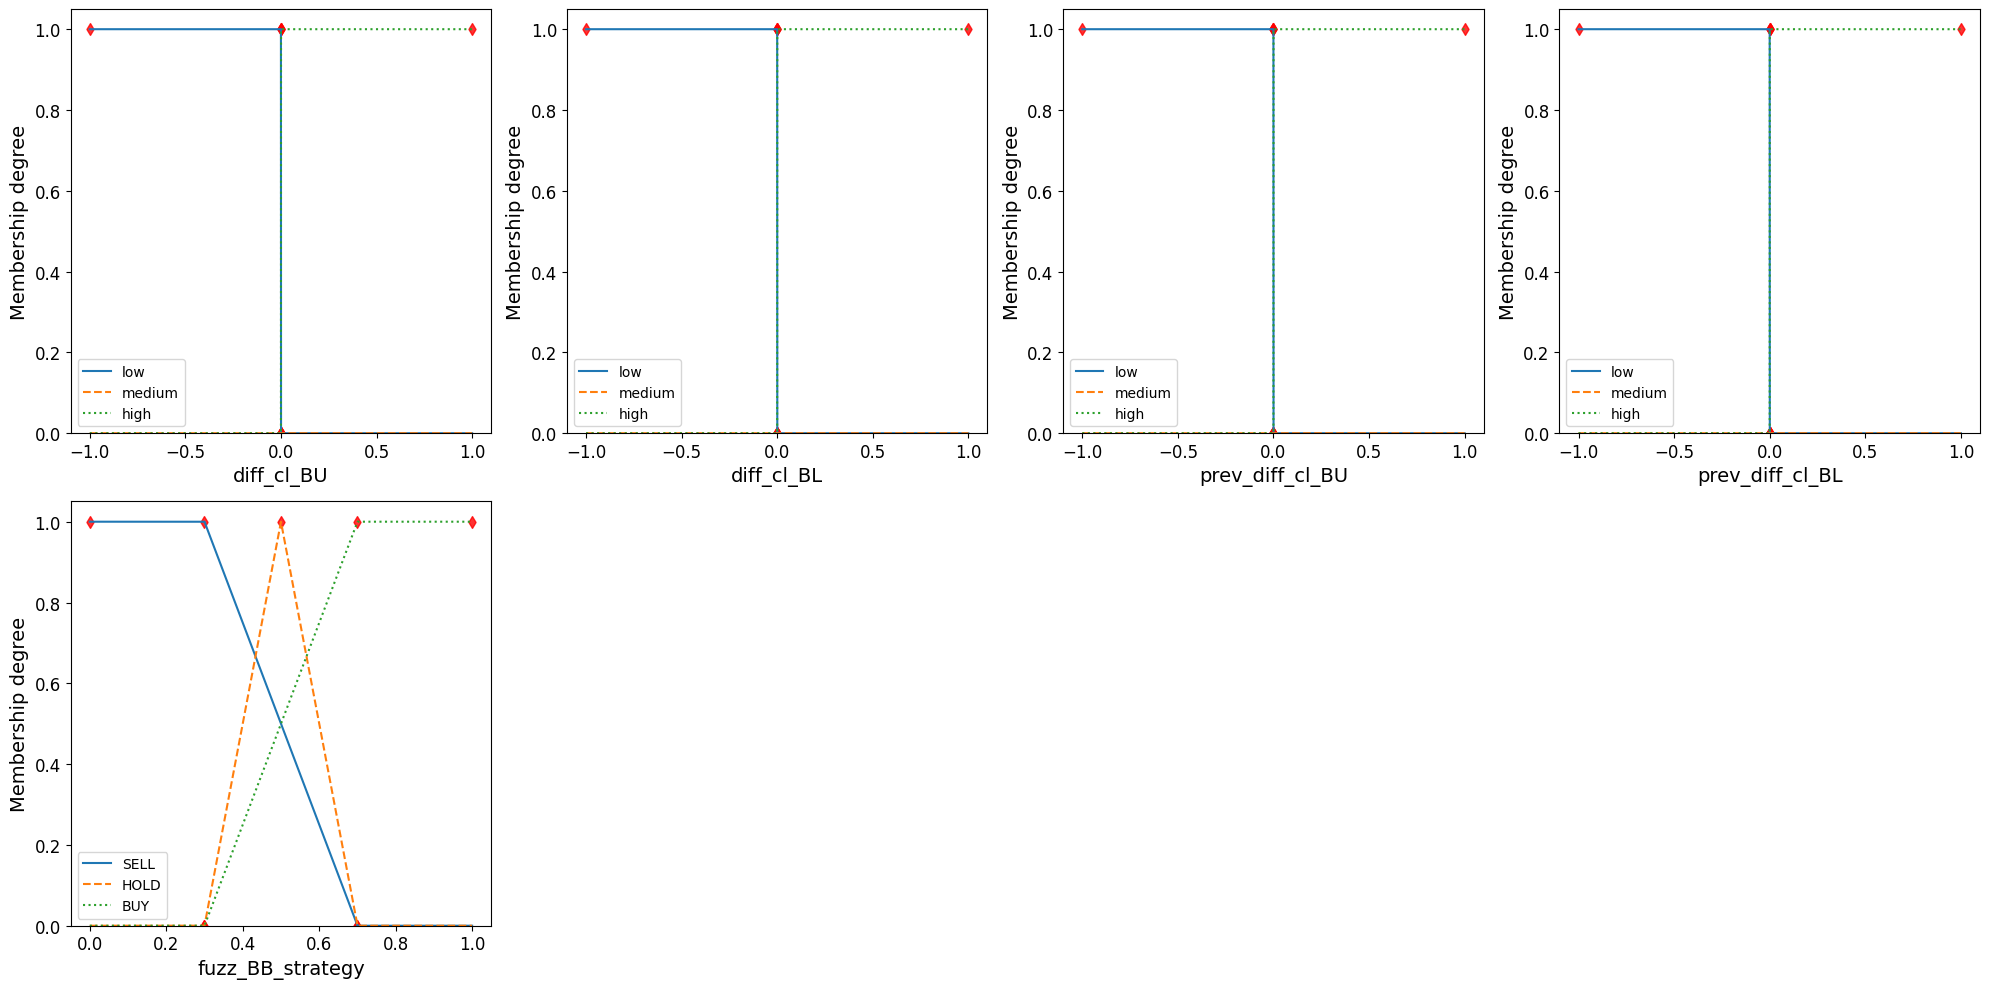

In [80]:
FS.produce_figure('fuzz_BB_strategy')

In [81]:
data['fuzz_BB_strategy'].value_counts()

fuzz_BB_strategy
HOLD    4857
SELL     317
BUY      125
Name: count, dtype: int64

# Bollinger Bands backtesting

In [82]:
data['dec_bollinger'] = data['dec_bollinger'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})
data['fuzz_BB_strategy'] = data['fuzz_BB_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

### Sharp

In [188]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['dec_bollinger'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
# bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    1284.0
Duration                               1284.0
Exposure Time [%]                   94.863813
Equity Final [$]                 10001.917165
Equity Peak [$]                  10001.923432
Return [%]                           0.019172
Buy & Hold Return [%]               -3.989744
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.017311
Avg. Drawdown [%]                   -0.000687
Max. Drawdown Duration                  511.0
Avg. Drawdown Duration               19.16129
# Trades                                 69.0
Win Rate [%]                        76.811594
Best Trade [%]                      13.933861
Worst Trade [%]                     -8.890118
Avg. Trade [%]                    

### Fuzzy

In [189]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_BB_strategy'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = False)
# bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)

stats = bt.run()
bt.plot()
stats

Start                                     0.0
End                                    1284.0
Duration                               1284.0
Exposure Time [%]                   96.653696
Equity Final [$]                 10002.752801
Equity Peak [$]                  10004.598921
Return [%]                           0.027528
Buy & Hold Return [%]               -3.989744
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.033817
Avg. Drawdown [%]                   -0.003184
Max. Drawdown Duration                  437.0
Avg. Drawdown Duration              31.894737
# Trades                                 68.0
Win Rate [%]                        67.647059
Best Trade [%]                      17.961213
Worst Trade [%]                     -8.249843
Avg. Trade [%]                    

In [190]:
# data.to_csv("data/decisions_EURUSD_5Y.csv", encoding='utf-8-sig')

In [191]:
data.to_csv("data/decisions_EURUSD_5Y.csv", encoding='utf-8-sig', index=False,)

In [83]:
data.head()

id    name     Open    Close     High      Low  data_volume   
0  41482  EURUSD  1.06074  1.06056  1.06083  1.05995          0.0  \
1  41512  EURUSD  1.06297  1.06262  1.06334  1.06122          0.0   
2  41537  EURUSD  1.07050  1.07238  1.07308  1.07030          0.0   
3  41562  EURUSD  1.07777  1.07741  1.07798  1.07608          0.0   
4  41592  EURUSD  1.08650  1.08551  1.08655  1.08546          0.0   

             data_datetime timeframe    Name  ...  MACD_decision  diff_MACD   
0  2023-03-16 06:00:00.000        1h  EURUSD  ...              0   0.000000  \
1  2023-03-17 12:00:00.000        1h  EURUSD  ...              0  -0.000081   
2  2023-03-20 13:00:00.000        1h  EURUSD  ...              1   0.000504   
3  2023-03-21 14:00:00.000        1h  EURUSD  ...              0   0.001171   
4  2023-03-22 20:00:00.000        1h  EURUSD  ...              0   0.002049   

   diff_MACD_prev  fuzz_MACD_strategy  dec_bollinger  diff_cl_BU  diff_cl_BL   
0             NaN                  -1              0   -0.014942    0.007944  \
1        0.000000                   0              0   -0.012033    0.009974   
2       -0.000081                   0              0   -0.002606    0.019899   
3        0.000504                   0             -1    0.000201    0.025823   
4        0.001171                   0             -1    0.004444    0.036117   

   prev_diff_cl_BU  prev_diff_cl_BL  fuzz_BB_strategy  
0              NaN              NaN                 0  
1        -0.014942         0.007944                 0  
2        -0.012033         0.009974                 0  
3        -0.002606         0.019899                -1  
4         0.000201         0.025823                -1  

[5 rows x 50 columns]

In [84]:
drop_first = data.drop(data.index[0])
drop_first.head()

id    name     Open    Close     High      Low  data_volume   
1  41512  EURUSD  1.06297  1.06262  1.06334  1.06122          0.0  \
2  41537  EURUSD  1.07050  1.07238  1.07308  1.07030          0.0   
3  41562  EURUSD  1.07777  1.07741  1.07798  1.07608          0.0   
4  41592  EURUSD  1.08650  1.08551  1.08655  1.08546          0.0   
5  41617  EURUSD  1.08304  1.08326  1.08338  1.08293          0.0   

             data_datetime timeframe    Name  ...  MACD_decision  diff_MACD   
1  2023-03-17 12:00:00.000        1h  EURUSD  ...              0  -0.000081  \
2  2023-03-20 13:00:00.000        1h  EURUSD  ...              1   0.000504   
3  2023-03-21 14:00:00.000        1h  EURUSD  ...              0   0.001171   
4  2023-03-22 20:00:00.000        1h  EURUSD  ...              0   0.002049   
5  2023-03-23 21:00:00.000        1h  EURUSD  ...              0   0.002347   

   diff_MACD_prev  fuzz_MACD_strategy  dec_bollinger  diff_cl_BU  diff_cl_BL   
1        0.000000                   0              0   -0.012033    0.009974  \
2       -0.000081                   0              0   -0.002606    0.019899   
3        0.000504                   0             -1    0.000201    0.025823   
4        0.001171                   0             -1    0.004444    0.036117   
5        0.002049                   0              0   -0.000444    0.035033   

   prev_diff_cl_BU  prev_diff_cl_BL  fuzz_BB_strategy  
1        -0.014942         0.007944                 0  
2        -0.012033         0.009974                 0  
3        -0.002606         0.019899                -1  
4         0.000201         0.025823                -1  
5         0.004444         0.036117                 0  

[5 rows x 50 columns]

In [85]:
drop_first.to_csv("data/decisions_EURUSD_1H.csv", encoding='utf-8-sig', index=False,)

In [195]:
# drop_first.to_csv("data/decisions_EURUSD_5Y.csv", encoding='utf-8-sig', index=False,)

## [References](#References)

#### [Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)

exclusive_orders = False/True - sprawdzić czy lepiej 
przy rozmywaniu w pętli for zmienic progi decyzyjne
przy tworzeniu strategii sprawdzić jak działa sl i zastosować
pobawić się z stop loss i take profit


def init(self):
        super().init()
        signal = self.set_signal(data['dec_rsi'])
        if signal == 1: #rozne od self.position.long
            self.buy(size=.4, sl=.9)
        elif signal == -1:
            self.sell(size=.4, sl=.9)
        super().next()

- Ustalić długość okresu;
- Dodać inne instrumenty (po skończeniu backtestingu i zatwierdzeniu ustawień);

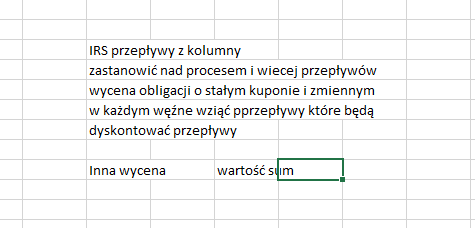

2 eseje

jeden z użyciem tylko GPT (15k znaków)

drugi co sądze o eseju co napisał chat (10k znaków)

opisać listę wejściową do chatu
wytknąć błędy 
sposób udoskonalania


TERMIN: 27.06

71T@DSm24 - biznes w it